In [1]:
sc.install_pypi_package("matplotlib==3.3.0")
sc.install_pypi_package("pandas==0.24.2")
sc.install_pypi_package("tensorflow==1.14.0")
sc.install_pypi_package("sklearn")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1597012298810_0178,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/1c/15/3fea1bfb7e5b77b7cca9c6010a9cabc58ea125385345ecb6f5832eb8b49a/matplotlib-3.3.0-1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e8/f2/6722dd0c22e3a143ac792ccb2424924ac72af4adea756b1165b4cad50da7/Pillow-7.2.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/31/b9/6202dcae729998a0ade30e80ac00f616542ef445b088ec970d407dfd41c0/kiwisolver-1.2.0-cp37-cp37m-manylinux1_x86_64.whl

  Us

[]

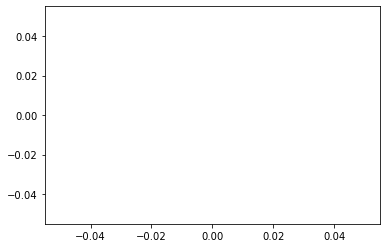

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot()

In [17]:
import urllib
import operator
import numpy as np 
import pandas as pd
import tensorflow as tf
from pyspark.sql import Row
from pyspark.sql import Window
from pyspark import SQLContext

from pyspark.sql import functions as F
from pyspark.sql.functions import when, count, col

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# Used for normalizing and scaling close prices
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Creating pySpark Context 
sqlContext = SQLContext(sc)

# Loading data from mounted s3 bucket
data = sqlContext.read.options(header = 'true', inferschema = 'true').csv("s3://bigdatasu20/all_stocks_5yr.csv")

# Selecting American Airlines Data
aal = data.filter("Name == 'AAL'")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# For Visualization of close prices with data
df = aal.toPandas()

df.loc[:, 'date'] = pd.to_datetime(df.loc[:,'date'], format="%Y/%m/%d")
df = df.sort_values('date')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df['close'])
plt.xticks(range(0,df.shape[0],50),df['date'].loc[::50],rotation=60)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing price',fontsize=18)
plt.legend()
plt.show()

NameError: name 'df' is not defined

<Figure size 1296x648 with 0 Axes>

In [7]:
# Selecting only close prices for predicition and converting them in to numpy array
close_list = aal.select('close').collect()
close_price = [row['close'] for row in close_list]
close_prices = np.array(close_price)

In [8]:
# Scaling close prices 
scaler = StandardScaler()
standardized_data = scaler.fit_transform(close_prices.reshape(-1,1))

In [9]:
# Calculating the split time to split train and test data
size = int(len(close_prices))
print("Size of Dataset", size)

# 80% train and 20% test data
split_time = int(size * 80 / 100)

print("Size of Training Dataset", split_time)
print("Size of Testing Dataset", size - split_time)

Size of Dataset 1259
Size of Training Dataset 1007
Size of Testing Dataset 252

In [10]:
# Preprocessing close prices so that all values are between 0 and 1
scaler = MinMaxScaler()

window_length = 50
for di in range(0, size, window_length):
    scaler.fit(standardized_data[di:di + window_length,:])
    standardized_data[di:di + window_length,:] = scaler.transform(standardized_data[di:di + window_length,:])

In [11]:
# Reshaping in to original data
scaled_data = standardized_data.reshape(-1)

In [12]:
# Smoothing using exponential moving average
exp_moving_avg = 0.0
gamma = 0.1
for i in range(split_time):
  exp_moving_avg = gamma * scaled_data[i] + (1-gamma)*exp_moving_avg
  scaled_data[i] = exp_moving_avg

In [13]:
# Splitting data in to train and test sets
trainingData = scaled_data[:split_time]
testingData = scaled_data[split_time:]

# Concatinating for visualization purposes
closingData = np.concatenate([trainingData,testingData],axis=0)

plt.figure(figsize = (18,9))
plt.plot(closingData, label='Scaled Close')
plt.xticks(range(0,df.shape[0],50),df['date'].loc[::50],rotation=60)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing price',fontsize=18)
plt.legend()
plt.show()

In [14]:
# Data Generator is used for training model
class DataGen(object):

    def __init__(self,prices, sizeOfBatch, numOfTimeSteps):
        self._Prices = prices
        self._pricesLength = len(self._Prices) - numOfTimeSteps
        self._sizeOfBatch = sizeOfBatch
        self._numOfTimeSteps = numOfTimeSteps
        self._batches = self._pricesLength // self._sizeOfBatch
        self._pointer = [_val * self._batches for _val in range(self._sizeOfBatch)]

    def upcomingBatch(self):

        batchData = np.zeros((self._sizeOfBatch),dtype=np.float32)
        batchLabels = np.zeros((self._sizeOfBatch),dtype=np.float32)

        for b in range(self._sizeOfBatch):
            if self._pointer[b]+1>=self._pricesLength:
                self._pointer[b] = np.random.randint(0,(b+1)*self._batches)

            batchData[b] = self._Prices[self._pointer[b]]
            batchLabels[b]= self._Prices[self._pointer[b]+np.random.randint(0,5)]

            self._pointer[b] = (self._pointer[b]+1)%self._pricesLength

        return batchData, batchLabels

#   This method unpack_future_batches will unpack batches of close prices data
    def unpack_future_batches(self):

        unpackData, unpackLabels = [],[]
        init_data, init_label = None,None
        for ui in range(self._numOfTimeSteps):

            data, labels = self.upcomingBatch()    

            unpackData.append(data)
            unpackLabels.append(labels)

        return unpackData, unpackLabels

    def resetIndices(self):
        for b in range(self._sizeOfBatch):
            self._pointer[b] = np.random.randint(0,min((b+1)*self._batches,self._pricesLength-1))

generatedData = DataGen(trainingData,5,5)
data_, labels_ = generatedData.unpack_future_batches()

In [15]:
# Parameters for LSTM model
D = 1
futureTimeSteps = 50
sizeOfBatch = 25
hiddenNodeCount = [256, 256, 128]
# Number of hidden layers
layerCount = len(hiddenNodeCount) 
# Dropuout Probability
dropout = 0.25

tf.compat.v1.reset_default_graph()

In [16]:
# We have to enable eager execution to enable some of the features
tf.compat.v1.disable_eager_execution()

# Input data
trainingInputs = []
trainingOutputs = []

for i in range(futureTimeSteps):
    trainingInputs.append(tf.compat.v1.placeholder(tf.float32, shape=[sizeOfBatch,D],name='trainingInputs%d'%i))
    trainingOutputs.append(tf.compat.v1.placeholder(tf.float32, shape=[sizeOfBatch,1], name = 'trainingOutputs%d'%i))

In [17]:
# Defining LSTM cell
LSTMCells = [
    tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=hiddenNodeCount[i],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for i in range(layerCount)]


# Using dropout LSTM cells to reduce overfitting
dropLSTMCells = [tf.compat.v1.nn.rnn_cell.DropoutWrapper(lstm, input_keep_prob=1.0, output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout) for lstm in LSTMCells]

dropMultiRNNCell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(dropLSTMCells)
multiRNNCell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(LSTMCells)

# Defining weights and bias for the model
w = tf.compat.v1.get_variable('w',shape=[hiddenNodeCount[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
initializer = tf.keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)
b = tf.compat.v1.get_variable('b',initializer=initializer(shape=[1]))

In [18]:
# Calculating and storing both cell and hidden state
cellState, hiddenState = [],[]
initialState = []
for i in range(layerCount):
  cellState.append(tf.Variable(tf.zeros([sizeOfBatch, hiddenNodeCount[i]]), trainable=False))
  hiddenState.append(tf.Variable(tf.zeros([sizeOfBatch, hiddenNodeCount[i]]), trainable=False))
  initialState.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(cellState[i], hiddenState[i]))

inputs = tf.concat([tf.expand_dims(t,0) for t in trainingInputs],axis=0)

LSTMOutputs, state = tf.compat.v1.nn.dynamic_rnn(
    dropMultiRNNCell, inputs, initial_state=tuple(initialState),
    time_major = True, dtype=tf.float32)

# Feeding the sate to get predictions
LSTMOutputs = tf.reshape(LSTMOutputs, [sizeOfBatch*futureTimeSteps,hiddenNodeCount[-1]])

allOutputs = tf.compat.v1.nn.xw_plus_b(LSTMOutputs,w,b)

split_outputs = tf.split(allOutputs,futureTimeSteps,axis=0)

In [19]:
# Calculating loss which is Mean Squared Error
loss = 0.0
with tf.compat.v1.control_dependencies([tf.compat.v1.assign(cellState[i], state[i][0]) for i in range(layerCount)]+
                             [tf.compat.v1.assign(hiddenState[i], state[i][1]) for i in range(layerCount)]):
  for k in range(futureTimeSteps):
    loss += tf.reduce_mean(0.5*(split_outputs[k]-trainingOutputs[k])**2)

# Learning rate decay
Gstep = tf.Variable(0, trainable=False)
GStepInc = tf.compat.v1.assign(Gstep,Gstep + 1)
tfLr = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)
tfMinLr = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)

lr = tf.maximum(tf.compat.v1.train.exponential_decay(tfLr, Gstep, decay_steps=1, decay_rate=0.5, staircase=True),tfMinLr)

# Defining optimizer nad used Adam 
optimizer = tf.compat.v1.train.AdamOptimizer(lr)
grads, v = zip(*optimizer.compute_gradients(loss))
grads, _ = tf.clip_by_global_norm(grads, 5.0)
optimizer = optimizer.apply_gradients(zip(grads, v))

In [20]:
sampleInputs = tf.compat.v1.placeholder(tf.float32, shape=[1,D])

# Storing LSTM state which will be used later for predicting output

cell, hidden, sampleInitialState = [],[],[]
for i in range(layerCount):
  cell.append(tf.Variable(tf.zeros([1, hiddenNodeCount[i]]), trainable=False))
  hidden.append(tf.Variable(tf.zeros([1, hiddenNodeCount[i]]), trainable=False))
  sampleInitialState.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(cell[i],hidden[i]))

#   Resetting both state variables
sampleStateReset = tf.group(*[tf.compat.v1.assign(cell[i],tf.zeros([1, hiddenNodeCount[i]])) for i in range(layerCount)],
                            *[tf.compat.v1.assign(hidden[i],tf.zeros([1, hiddenNodeCount[i]])) for i in range(layerCount)])

sampleOutput, sampleState = tf.compat.v1.nn.dynamic_rnn(multiRNNCell, 
                                                            tf.expand_dims(sampleInputs,0),
                                                            initial_state=tuple(sampleInitialState),
                                                            time_major = True,
                                                            dtype=tf.float32)

with tf.control_dependencies([tf.compat.v1.assign(cell[i],sampleState[i][0]) for i in range(layerCount)]+
                              [tf.compat.v1.assign(hidden[i],sampleState[i][1]) for i in range(layerCount)]):  
  predictionSample = tf.compat.v1.nn.xw_plus_b(tf.reshape(sampleOutput,[1,-1]), w, b)

In [21]:
# Training and predicting close values of AAL stocks using LSTM
NoOfEpochs = 30
test_interval = 1

stepsPerPredicition = 10

trainingLength = trainingData.size

# Storing MSE losses for training and testing
training_MSELoss = []
testing_MSELoss = []
predictions = []
lossHistory = {}

session = tf.compat.v1.InteractiveSession()

tf.compat.v1.global_variables_initializer().run()

# Keeping track of changes in loss
lossCount = 0
lossThreshold = 2
avgLoss = 0

dataGen = DataGen(trainingData,sizeOfBatch,futureTimeSteps)

xAxis = []

# Test predictions from here
test_points_seq = np.arange(1007, 1258-5, 10).tolist()

for epoch in range(NoOfEpochs):       

# Training
    for s in range(trainingLength//sizeOfBatch):

        data_, labels_ = dataGen.unpack_future_batches()

        dict = {}
        for i,(data,label) in enumerate(zip(data_,labels_)):            
            dict[trainingInputs[i]] = data.reshape(-1,1)
            dict[trainingOutputs[i]] = label.reshape(-1,1)

        dict.update({tfLr: 0.0001, tfMinLr:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=dict)

        avgLoss += l

# Validation
    if (epoch + 1) % test_interval == 0:

      avgLoss = avgLoss/(test_interval*(trainingLength//sizeOfBatch))

      # Calculating ahe average loss
      if (epoch + 1)%test_interval==0:
        print("[========== Epoch %d/%d ==========]" % (epoch + 1, NoOfEpochs))
        print("Average Validation Loss: %f" % (avgLoss))

      training_MSELoss.append(avgLoss)

      avgLoss = 0

      predictionsSeq = []

      MSETestLoss = []

# Calculating Predictions
      for w in test_points_seq:
        MSE_Testloss = 0.0
        ourPredictions = []

        if (epoch + 1) - test_interval==0:
           x_Axis_=[]

# Sending this to recent state of stock prices
        for j in range(w-futureTimeSteps+1,w-1):
          currentPrice = closingData[j]
          dict[sampleInputs] = np.array(currentPrice).reshape(1,1)    
          _ = session.run(predictionSample, feed_dict=dict)

        dict = {}

        currentPrice = closingData[w-1]

        dict[sampleInputs] = np.array(currentPrice).reshape(1,1)

        for p in range(stepsPerPredicition):
          pred = session.run(predictionSample,feed_dict=dict)
          ourPredictions.append(pred.item())
          dict[sampleInputs] = np.asarray(pred).reshape(-1,1)

          if (epoch + 1)-test_interval==0:
            x_Axis_.append(w+p)
            
          MSE_Testloss += 0.5*(pred-closingData[w+p])**2

        session.run(sampleStateReset)
        predictionsSeq.append(np.array(ourPredictions))

        MSE_Testloss /= stepsPerPredicition
        MSETestLoss.append(MSE_Testloss)

        if (epoch + 1)-test_interval==0:
          xAxis.append(x_Axis_)

      current_test_mse = np.mean(MSETestLoss)

# Performing Decay of Learning Rate
      if len(testing_MSELoss)>0 and current_test_mse > min(testing_MSELoss):
          lossCount += 1
      else:
          lossCount = 0

      if lossCount > lossThreshold :
            session.run(GStepInc)
            lossCount = 0
            print('Because the test error rate has not increased in the last 2 epochs we are decreasing learning rate by 0.5')

      testing_MSELoss.append(current_test_mse)
      print('MSE of the Testing Data: %f'%np.mean(MSETestLoss))
#       Storing loss history to use it in next step for plotting the loss for best epoch
      lossHistory[epoch+1] =  np.mean(MSETestLoss)
      predictions.append(predictionsSeq)

/databricks/python/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
 warnings.warn('An interactive session is already active. This can '
[========== Epoch 1/30 ==========]
Average Validation Loss: 0.361951
MSE of the Testing Data: 0.052015
[========== Epoch 2/30 ==========]
Average Validation Loss: 0.138214
MSE of the Testing Data: 0.038964
[========== Epoch 3/30 ==========]
Average Validation Loss: 0.101834
MSE of the Testing Data: 0.040723
[========== Epoch 4/30 ==========]
Average Validation Loss: 0.081227
MSE of the Testing Data: 0.051159
[========== Epoch 5/30 ==========]
Average Validation Loss: 0.073423
Because the test error rate has not increased in the last 2 epochs we are decreasing learning rate by 0.5
MSE of the Testing Data: 0.059973
[========== Epoch 6/30 ==========]
Average Validation Loss: 0.065542
MSE of the Testing Data: 0.060181
[========== Epoch 7/30 ==========]
Average Validation Loss: 0.063151
MSE of the Testing Data: 0.054310
[========== Epoch 8/30 ==========]
Average Validation Loss: 0.063651
Because the test error rate has not increased in the last 2 epochs we are decreasing learning rate by 0.5
MSE of the Testing Data: 0.065558
[========== Epoch 9/30 ==========]
Average Validation Loss: 0.060338
MSE of the Testing Data: 0.053893
[========== Epoch 10/30 ==========]
Average Validation Loss: 0.060317
MSE of the Testing Data: 0.051545
[========== Epoch 11/30 ==========]
Average Validation Loss: 0.058954
Because the test error rate has not increased in the last 2 epochs we are decreasing learning rate by 0.5
MSE of the Testing Data: 0.053459
[========== Epoch 12/30 ==========]
Average Validation Loss: 0.055911
MSE of the Testing Data: 0.053520
[========== Epoch 13/30 ==========]
Average Validation Loss: 0.057880
MSE of the Testing Data: 0.052734
[========== Epoch 14/30 ==========]
Average Validation Loss: 0.057940
Because the test error rate has not increased in the last 2 epochs we are decreasing learning rate by 0.5
MSE of the Testing Data: 0.050429
[========== Epoch 15/30 ==========]
Average Validation Loss: 0.055376
MSE of the Testing Data: 0.049988
[========== Epoch 16/30 ==========]
Average Validation Loss: 0.056449
MSE of the Testing Data: 0.052779
[========== Epoch 17/30 ==========]
Average Validation Loss: 0.055098
Because the test error rate has not increased in the last 2 epochs we are decreasing learning rate by 0.5
MSE of the Testing Data: 0.053503
[========== Epoch 18/30 ==========]
Average Validation Loss: 0.055683
MSE of the Testing Data: 0.049396
[========== Epoch 19/30 ==========]
Average Validation Loss: 0.053801
MSE of the Testing Data: 0.051862
[========== Epoch 20/30 ==========]
Average Validation Loss: 0.056903
Because the test error rate has not increased in the last 2 epochs we are decreasing learning rate by 0.5
MSE of the Testing Data: 0.049897
[========== Epoch 21/30 ==========]
Average Validation Loss: 0.053802
MSE of the Testing Data: 0.052760
[========== Epoch 22/30 ==========]
Average Validation Loss: 0.053387
MSE of the Testing Data: 0.052145
[========== Epoch 23/30 ==========]
Average Validation Loss: 0.055560
Because the test error rate has not increased in the last 2 epochs we are decreasing learning rate by 0.5
MSE of the Testing Data: 0.051476
[========== Epoch 24/30 ==========]
Average Validation Loss: 0.053673
MSE of the Testing Data: 0.051765
[========== Epoch 25/30 ==========]
Average Validation Loss: 0.055190
MSE of the Testing Data: 0.052162
[========== Epoch 26/30 ==========]
Average Validation Loss: 0.053371
Because the test error rate has not increased in the last 2 epochs we are decreasing learning rate by 0.5
MSE of the Testing Data: 0.051490
[========== Epoch 27/30 ==========]
Average Validation Loss: 0.054452
MSE of the Te

In [22]:
# Selecting epoch with least loss
epochWithLeastLoss = min(lossHistory.items(), key=operator.itemgetter(1))[0]

In [23]:
# Storing predictions from the best epoch
preds = []
for xval,yval in zip(xAxis,predictions[epochWithLeastLoss-1]):
  preds.append(yval)
  
flattened = [val for sublist in preds for val in sublist]

In [24]:
# Visuzlizing true values and predicted values of test data
plt.figure(figsize = (18,9))

plt.plot(testingData, label="True")
plt.plot(flattened, label="Predicted")
plt.title('True Values vs Predicted Close Prices',fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)

plt.legend()
plt.show()

In [25]:
# Visualizing loss for each epoch
plt.figure(figsize = (18,9))
plt.plot(lossHistory.values())
plt.title('MSE Test Loss for each Epoch',fontsize=18)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('MSE', fontsize=15)

In [26]:
# Calculating MAE
mae = tf.keras.losses.MeanAbsoluteError()
loss = mae(testingData[:-2], flattened)
print("Mean Absolute Error",loss.eval())

Mean Absolute Error 0.22561

In [27]:
# Calculating MSE
mse = min(lossHistory.items(), key=operator.itemgetter(1))[1]
print("Mean Squared Error",mse)

Mean Squared Error 0.038963865

In [28]:
# Calculating MSLE
msle = tf.keras.losses.MSLE(testingData[:-2], flattened)
print("Mean Squared Logarithmic Error", msle.eval())

Mean Squared Logarithmic Error 0.033963103

In [29]:
session.close()